In [1]:
import os
import sleep_study as ss
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import scipy

In [2]:
ss.init()

age information stored in /home/harlinl/sleep_study_harlin/age_file.csv


In [3]:
diag_df = ss.info.load_health_info('DIAGNOSIS.csv')
print('dx columns', diag_df.columns)
print(len(diag_df))
enc_df = ss.info.load_health_info('SLEEP_ENC_ID.csv')
print('enc columns', enc_df.columns)
print(len(enc_df))

/home/harlinl/anaconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


dx columns Index(['STUDY_DX_ID', 'STUDY_ENC_ID', 'STUDY_PAT_ID', 'DX_START_DATETIME',
       'DX_END_DATETIME', 'DX_SOURCE_TYPE', 'DX_ENC_TYPE', 'DX_CODE_TYPE',
       'DX_CODE', 'DX_NAME', 'DX_ALT_CODE', 'CLASS_OF_PROBLEM', 'CHRONIC_YN',
       'PROV_ID'],
      dtype='object')
1513853
enc columns Index(['STUDY_PAT_ID', 'SLEEP_STUDY_ID', 'STUDY_ENC_ID'], dtype='object')
3964


In [4]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_colwidth', None)
tmp = diag_df[["STUDY_PAT_ID","STUDY_ENC_ID", "DX_SOURCE_TYPE", "DX_ENC_TYPE", "DX_CODE_TYPE", "DX_CODE", "DX_NAME", "DX_ALT_CODE"]]
tmp.iloc[:15]

,STUDY_PAT_ID,STUDY_ENC_ID,DX_SOURCE_TYPE,DX_ENC_TYPE,DX_CODE_TYPE,DX_CODE,DX_NAME,DX_ALT_CODE
0,13210,55902925,Primary Encounter Dx,Encounter Dx,ICD10,R56.9,Seizure,780.39
1,12547,55772269,Secondary Encounter Dx,Encounter Dx,ICD9,790.7,Positive blood culture,R78.81
2,12547,55772269,Admit Dx,Admit Dx,ICD9,796.4,Other abnormal clinical finding,R68.89
3,12547,55772269,Final Dx,Final Dx,ICD9,796.4,Other abnormal clinical finding,R68.89
4,7138,56359534,Secondary Encounter Dx,Encounter Dx,ICD10,J06.9,Viral URI,465.9
5,7138,56359534,Secondary Encounter Dx,Encounter Dx,ICD10,R56.9,Seizures,780.39
6,7138,56359534,Primary Encounter Dx,Encounter Dx,ICD10,R50.9,Fever in pediatric patient,780.60
7,7138,56359534,Admit Dx,Admit Dx,ICD10,R50.9,"Fever, unspecified",NaN
8,7138,56359534,Final Dx,Final Dx,ICD10,R50.9,"Fever, unspecified",NaN
9,7138,56359534,Final Dx,Final Dx,ICD10,J06.9,"Acute upper respiratory infection, unspecified",NaN


In [5]:
def getOnlyFinalDX(df):
    dx_final = df[df["DX_SOURCE_TYPE"]=="Final Dx"].reset_index(drop=True)
    dx_final = dx_final.drop(["DX_SOURCE_TYPE", "DX_ENC_TYPE"], 1)
    return dx_final

In [6]:
def getAllICD10(df):
    # change all ICD9 -> ICD10, delete the 75 lines without corresponding ICD10
    print('how many are ICD9 vs. ICD10')
    print(df["DX_CODE_TYPE"].value_counts())
    print()

    tmp = df[df["DX_CODE_TYPE"]=='ICD9']
    tmp = tmp[tmp["DX_ALT_CODE"].isna()]
    print(len(tmp), 'ICD9 rows do NOT have DX_ALT_CODE')
    print('These ICD9 codes dont have equivalent ICD10 codes')
    print()
    print(tmp["DX_NAME"].value_counts())
    print(tmp["DX_CODE"].value_counts())
    print()
    
    dx_final = df[~((df["DX_CODE_TYPE"]=='ICD9') & df["DX_ALT_CODE"].isna())].reset_index(drop=True)
    print('once we take those out, how many are ICD9 vs. ICD10')
    print(df["DX_CODE_TYPE"].value_counts())
    print()
    
    tmp_alt = dx_final.loc[(dx_final["DX_CODE_TYPE"]=='ICD9'), "DX_ALT_CODE"]
    dx_final.loc[(dx_final["DX_CODE_TYPE"]=='ICD9'), "DX_ALT_CODE"] = dx_final.loc[(dx_final["DX_CODE_TYPE"]=='ICD9'), "DX_CODE"]
    dx_final.loc[(dx_final["DX_CODE_TYPE"]=='ICD9'), "DX_CODE"] = tmp_alt
    dx_final.loc[(dx_final["DX_CODE_TYPE"]=='ICD9'), "DX_CODE_TYPE"] = "ICD10"
    
    dx_final = dx_final.drop(["DX_CODE_TYPE", "DX_ALT_CODE"], 1)

    return dx_final

In [7]:
def getOneCodePerEntry(df):
    dx_final = df.copy()
    # change lists of dx codes to multiple lines of entry
    dx_final["num_codes"] = dx_final["DX_CODE"].apply(lambda x: len(x.split(",")))
    print(dx_final["num_codes"].value_counts())

    to_append = {}
    for col in dx_final.columns:
        to_append[col] = []

    multiple_codes = dx_final[dx_final["num_codes"] > 1].reset_index(drop=True)
    for row in multiple_codes.iterrows():
        row = row[1]
        codes = row["DX_CODE"].split(",")
        for c in codes:
            for ind in row.index:
                if ind == "DX_CODE":
                    to_append["DX_CODE"].append(c.strip())
                elif ind == "num_codes":
                    to_append["num_codes"].append(1)
                else:
                    to_append[ind].append(row[ind])

    dx_final.drop(dx_final[dx_final['num_codes'] >1].index, inplace = True)
    print(dx_final["num_codes"].value_counts())

    dx_final = dx_final.append(pd.DataFrame(to_append), ignore_index=True)

    print(dx_final["num_codes"].value_counts())
    print(dx_final["DX_CODE"].nunique())
    dx_final.drop(["num_codes", "CLASS_OF_PROBLEM", "CHRONIC_YN" , "PROV_ID"], 1, inplace = True)
    return dx_final

In [8]:
# just final dx
print('diagnosis.csv has', len(diag_df), 'rows')
dx_final = getOnlyFinalDX(diag_df)
dx_final[:10]

diagnosis.csv has 1513853 rows


,STUDY_DX_ID,STUDY_ENC_ID,STUDY_PAT_ID,DX_START_DATETIME,DX_END_DATETIME,DX_CODE_TYPE,DX_CODE,DX_NAME,DX_ALT_CODE,CLASS_OF_PROBLEM,CHRONIC_YN,PROV_ID
0,10019,55772269,12547,2014-11-01 19:58:00,2014-11-01 23:08:00,ICD9,796.4,Other abnormal clinical finding,R68.89,NaN,NaN,3001267.0
1,10024,56359534,7138,2019-05-18 22:50:00,2019-05-19 01:03:00,ICD10,R50.9,"Fever, unspecified",NaN,NaN,NaN,3001267.0
2,10025,56359534,7138,2019-05-18 22:50:00,2019-05-19 01:03:00,ICD10,J06.9,"Acute upper respiratory infection, unspecified",NaN,NaN,NaN,3001267.0
3,10026,56359534,7138,2019-05-18 22:50:00,2019-05-19 01:03:00,ICD10,R56.9,Unspecified convulsions,NaN,NaN,NaN,3001267.0
4,10030,57008140,18889,2017-12-20 14:05:00,2017-12-20 18:49:00,ICD10,K52.9,"Noninfective gastroenteritis and colitis, unspecified",NaN,NaN,NaN,3001267.0
5,10035,56394967,2842,2014-10-26 00:24:00,2014-10-26 02:16:00,ICD9,959.01,"Head injury, unspecified",S09.90XA,NaN,NaN,3001267.0
6,10036,56394967,2842,2014-10-26 00:24:00,2014-10-26 02:16:00,ICD9,873.0,"Open wound of scalp, without mention of complication",S01.00XA,NaN,NaN,3001267.0
7,10040,56579248,17902,2014-08-07 18:10:00,2014-08-07 20:15:00,ICD9,528.00,"Stomatitis and mucositis, unspecified","K12.1, K12.30",NaN,NaN,3001267.0
8,10045,55661917,8065,2017-02-26 18:53:00,2017-02-27 00:14:00,ICD10,R10.31,Right lower quadrant pain,NaN,NaN,NaN,3001267.0
9,10049,55527430,1258,2016-09-07 19:22:00,2016-09-07 22:10:00,ICD10,R50.9,"Fever, unspecified",NaN,NaN,NaN,3001267.0


In [9]:
# change all ICD9 -> ICD10, delete the 75 lines without corresponding ICD10
dx_final = getAllICD10(dx_final)
dx_final.iloc[:10]

how many are ICD9 vs. ICD10
ICD10    371714
ICD9     225940
Name: DX_CODE_TYPE, dtype: int64

75 ICD9 rows do NOT have DX_ALT_CODE
These ICD9 codes dont have equivalent ICD10 codes

Congenital anomalies of pulmonary artery                                                           18
Pulmonary insufficiency following trauma and surgery                                               10
Pancytopenia                                                                                        7
Incontinence of feces                                                                               7
Renal dialysis status                                                                               6
Escherichia coli (E. coli) infection in conditions classified elsewhere and of unspecified site     5
Digestive system complication                                                                       4
Hypertr obst cardiomyop                                                                             4
He

,STUDY_DX_ID,STUDY_ENC_ID,STUDY_PAT_ID,DX_START_DATETIME,DX_END_DATETIME,DX_CODE,DX_NAME,CLASS_OF_PROBLEM,CHRONIC_YN,PROV_ID
0,10019,55772269,12547,2014-11-01 19:58:00,2014-11-01 23:08:00,R68.89,Other abnormal clinical finding,NaN,NaN,3001267.0
1,10024,56359534,7138,2019-05-18 22:50:00,2019-05-19 01:03:00,R50.9,"Fever, unspecified",NaN,NaN,3001267.0
2,10025,56359534,7138,2019-05-18 22:50:00,2019-05-19 01:03:00,J06.9,"Acute upper respiratory infection, unspecified",NaN,NaN,3001267.0
3,10026,56359534,7138,2019-05-18 22:50:00,2019-05-19 01:03:00,R56.9,Unspecified convulsions,NaN,NaN,3001267.0
4,10030,57008140,18889,2017-12-20 14:05:00,2017-12-20 18:49:00,K52.9,"Noninfective gastroenteritis and colitis, unspecified",NaN,NaN,3001267.0
5,10035,56394967,2842,2014-10-26 00:24:00,2014-10-26 02:16:00,S09.90XA,"Head injury, unspecified",NaN,NaN,3001267.0
6,10036,56394967,2842,2014-10-26 00:24:00,2014-10-26 02:16:00,S01.00XA,"Open wound of scalp, without mention of complication",NaN,NaN,3001267.0
7,10040,56579248,17902,2014-08-07 18:10:00,2014-08-07 20:15:00,"K12.1, K12.30","Stomatitis and mucositis, unspecified",NaN,NaN,3001267.0
8,10045,55661917,8065,2017-02-26 18:53:00,2017-02-27 00:14:00,R10.31,Right lower quadrant pain,NaN,NaN,3001267.0
9,10049,55527430,1258,2016-09-07 19:22:00,2016-09-07 22:10:00,R50.9,"Fever, unspecified",NaN,NaN,3001267.0


In [10]:
# change lists of dx codes to multiple lines of entry
dx_final = getOneCodePerEntry(dx_final)
dx_final.iloc[:10]

1    592826
2      4118
3       618
4        16
5         1
Name: num_codes, dtype: int64
1    592826
Name: num_codes, dtype: int64
1    602985
Name: num_codes, dtype: int64
7676


,STUDY_DX_ID,STUDY_ENC_ID,STUDY_PAT_ID,DX_START_DATETIME,DX_END_DATETIME,DX_CODE,DX_NAME
0,10019,55772269,12547,2014-11-01 19:58:00,2014-11-01 23:08:00,R68.89,Other abnormal clinical finding
1,10024,56359534,7138,2019-05-18 22:50:00,2019-05-19 01:03:00,R50.9,"Fever, unspecified"
2,10025,56359534,7138,2019-05-18 22:50:00,2019-05-19 01:03:00,J06.9,"Acute upper respiratory infection, unspecified"
3,10026,56359534,7138,2019-05-18 22:50:00,2019-05-19 01:03:00,R56.9,Unspecified convulsions
4,10030,57008140,18889,2017-12-20 14:05:00,2017-12-20 18:49:00,K52.9,"Noninfective gastroenteritis and colitis, unspecified"
5,10035,56394967,2842,2014-10-26 00:24:00,2014-10-26 02:16:00,S09.90XA,"Head injury, unspecified"
6,10036,56394967,2842,2014-10-26 00:24:00,2014-10-26 02:16:00,S01.00XA,"Open wound of scalp, without mention of complication"
7,10045,55661917,8065,2017-02-26 18:53:00,2017-02-27 00:14:00,R10.31,Right lower quadrant pain
8,10049,55527430,1258,2016-09-07 19:22:00,2016-09-07 22:10:00,R50.9,"Fever, unspecified"
9,10050,55527430,1258,2016-09-07 19:22:00,2016-09-07 22:10:00,J06.9,"Acute upper respiratory infection, unspecified"


# ICD codes

In [11]:
def truncateICDcodes(x, place=0):
    # x can be a list of codes
    # split by commas (,) -> take string before period (.) -> take only unique values -> return as comma separated string
    if place == 0:
        return ", ".join(np.unique([c.split(".")[0].strip() for c in str(x).split(",")]))
    else:
        res = []
        for c in str(x).split(","):
            if len(c.split(".")[-1].strip()) >= place:
                res.append(".".join([c.split(".")[0].strip(), c.split(".")[-1].strip()[:place]]))
            else:
                res.append(c)
        return ", ".join(np.unique(res))

s = 'R50.9'
print(s, '->', truncateICDcodes(s))
print(s, '->', truncateICDcodes(s, 1))
print()
s = '959.01'
print(s, '->', truncateICDcodes(s))
print(s, '->', truncateICDcodes(s, 1))
print(s, '->', truncateICDcodes(s, 2))
print()
s = '31.12, 31.1, 528.70, 512.0'
print(s, '->', truncateICDcodes(s))
print(s, '->', truncateICDcodes(s, 1))
print(s, '->', truncateICDcodes(s, 2))
print()
s = 'K12.1, K12.30, K15.3'
print(s, '->', truncateICDcodes(s))
print(s, '->', truncateICDcodes(s, 1))


R50.9 -> R50
R50.9 -> R50.9

959.01 -> 959
959.01 -> 959.0
959.01 -> 959.01

31.12, 31.1, 528.70, 512.0 -> 31, 512, 528
31.12, 31.1, 528.70, 512.0 -> 31.1, 512.0, 528.7
31.12, 31.1, 528.70, 512.0 ->  31.1,  512.0, 31.12, 528.70

K12.1, K12.30, K15.3 -> K12, K15
K12.1, K12.30, K15.3 -> K12.1, K12.3, K15.3


In [12]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_colwidth', None)

dx_final_10 = dx_final.copy()
dx_final_10["DX_CODE_INT"] = dx_final_10["DX_CODE"].apply(truncateICDcodes)
dx_final_10["DX_CODE_DEC1"] = dx_final_10["DX_CODE"].apply(lambda x: truncateICDcodes(x, 1))

print('final dx is', len(dx_final_10), 'rows')
print(dx_final_10.iloc[:20])

final dx is 602985 rows
    STUDY_DX_ID  STUDY_ENC_ID  STUDY_PAT_ID   DX_START_DATETIME  \
0         10019      55772269         12547 2014-11-01 19:58:00   
1         10024      56359534          7138 2019-05-18 22:50:00   
2         10025      56359534          7138 2019-05-18 22:50:00   
3         10026      56359534          7138 2019-05-18 22:50:00   
4         10030      57008140         18889 2017-12-20 14:05:00   
5         10035      56394967          2842 2014-10-26 00:24:00   
6         10036      56394967          2842 2014-10-26 00:24:00   
7         10045      55661917          8065 2017-02-26 18:53:00   
8         10049      55527430          1258 2016-09-07 19:22:00   
9         10050      55527430          1258 2016-09-07 19:22:00   
10        10056      56532061         10732 2019-03-01 00:06:00   
11        10059      56343697          3061 2017-10-01 11:23:00   
12        10063      55905490          7696 2016-06-09 13:31:00   
13        10064      55905490         

In [13]:
top_dx_dict = {'G47': "Sleep disorders",
'R06': "Abnormalities of breathing",
'Z23': "Encounter for immunization",
'J35': "Chronic diseases of tonsils and adenoids",
'Z00': "Encounter for general examination without complaint, suspected or reported diagnosis",
'J06': "Acute upper respiratory infections of multiple and unspecified sites",
'Z68': "Body mass index [BMI]",
'H66': "Suppurative and unspecified otitis media",
'R63': "Symptoms and signs concerning food and fluid intake",
'J02': "Acute pharyngitis",
'R09': "Other symptoms and signs involving the circulatory and respiratory system ",
'K59': "Other functional intestinal disorders",
'R05': "Cough",
'R62': "Lack of expected normal physiological development in childhood and adults",
'Z09': "Encounter for follow-up examination after completed treatment for conditions other than malignant neoplasm",
'R11': "Nausea and vomiting",
'R50': "Fever of other and unknown origin ",
'F80': "Specific developmental disorders of speech and language",
'J45': "Asthma",
'K21': "Gastro-esophageal reflux disease",
'J34': "Other and unspecified disorders of nose and nasal sinuses",
'E66': "Overweight and obesity",
'Z13': "Encounter for screening for other diseases and disorders",
'J30': "Vasomotor and allergic rhinitis",
'B97': "Viral agents as the cause of diseases classified elsewhere",
'R19': "Other symptoms and signs involving the digestive system and abdomen",
'R10': "Abdominal and pelvic pain",
'Z87': "Personal history of other diseases and conditions",
'Z98': "Other postprocedural states",
'H65':"Nonsuppurative otitis media"
}

unique_pt = dx_final_10.groupby("DX_CODE_INT")['STUDY_PAT_ID'].nunique().sort_values(ascending=False)
print(len(unique_pt))
#print(unique_pt[:30])

dx_names = unique_pt.index[:30].map(top_dx_dict)
#print(dx_names)
unique_pt = pd.DataFrame(data = {'DX_NAME_LONG': dx_names, "DX_CODE_INT": unique_pt.index[:30], 'UNIQUE_PT_COUNT': unique_pt.values[:30]})
unique_pt

1204


,DX_NAME_LONG,DX_CODE_INT,UNIQUE_PT_COUNT
0,Sleep disorders,G47,3379
1,Abnormalities of breathing,R06,2776
2,Encounter for immunization,Z23,1720
3,Chronic diseases of tonsils and adenoids,J35,1686
4,"Encounter for general examination without complaint, suspected or reported diagnosis",Z00,1587
5,Acute upper respiratory infections of multiple and unspecified sites,J06,1537
6,Body mass index [BMI],Z68,1417
7,Suppurative and unspecified otitis media,H66,1378
8,Symptoms and signs concerning food and fluid intake,R63,1369
9,Acute pharyngitis,J02,1260


In [14]:
g47_dict = {"G47.0": "Insomnia",
            "G47.1": "Hypersomnia",
            "G47.2": "Circadian rhythm sleep disorders",
            "G47.3": "Sleep apnea",
            "G47.4": "Narcolepsy and cataplexy",
            "G47.5": "Parasomnia",
            "G47.6": "Sleep related movement disorders",
            "G47.8": "Other sleep disorders",
            "G47.9": " Sleep disorder, unspecified"
}
only_g47 = dx_final_10[dx_final_10["DX_CODE_INT"]=='G47']
print(len(only_g47))

unique_pt = only_g47.groupby("DX_CODE_DEC1")['STUDY_PAT_ID'].nunique().sort_values(ascending=False)
dx_names = unique_pt.index.map(g47_dict)
#print(dx_names)
unique_pt = pd.DataFrame(data = {'DX_NAME_LONG': dx_names, "DX_CODE_DEC1": unique_pt.index, 'UNIQUE_PT_COUNT': unique_pt.values})
unique_pt = unique_pt.reset_index(drop=True)
unique_pt

16825


,DX_NAME_LONG,DX_CODE_DEC1,UNIQUE_PT_COUNT
0,Sleep apnea,G47.3,2558
1,"Sleep disorder, unspecified",G47.9,1163
2,Other sleep disorders,G47.8,914
3,Circadian rhythm sleep disorders,G47.2,566
4,Insomnia,G47.0,388
5,Hypersomnia,G47.1,257
6,Sleep related movement disorders,G47.6,180
7,Parasomnia,G47.5,165
8,Narcolepsy and cataplexy,G47.4,47


# PWS

In [15]:
def filterByPT(df, pt_list):
    return df[df["STUDY_PAT_ID"].isin(pt_list)].reset_index(drop=True)

def getPTsWithDX(diag_df, dx_code, starts_with=False):
    if starts_with:
        dx_df = diag_df[diag_df["DX_CODE"].str.startswith(dx_code)].reset_index(drop=True)
    else:
        dx_df = diag_df[diag_df["DX_CODE"]==dx_code].reset_index(drop=True)
    return dx_df["STUDY_PAT_ID"].unique().tolist()

def getPSGWithDX(enc_df, diag_df, dx_code):
    dx_df = diag_df[diag_df["DX_CODE"]==dx_code].reset_index(drop=True) # get all encounters with the dx code
    dx_df = enc_df[enc_df["STUDY_ENC_ID"].isin(dx_df["STUDY_ENC_ID"])].reset_index(drop=True) # only keep PSG encounters
    dx_df["file_name"] = dx_df["STUDY_PAT_ID"].astype(str).str.cat(dx_df["SLEEP_STUDY_ID"].astype(str), sep="_") # gross, but making filenames
    return dx_df

In [16]:
OSA_ss = getPSGWithDX(enc_df, dx_final, 'G47.33') # this is all the PSGs during which OSA was diagnosed.
print(len(OSA_ss))
print(OSA_ss["STUDY_PAT_ID"].nunique())
print(OSA_ss[:10])

PWS_PTS = getPTsWithDX(dx_final, 'Q87.11') # all PWS patients
print(len(PWS_PTS), PWS_PTS)

PWS_OSA = filterByPT(OSA_ss, PWS_PTS) # get OSA PSGs with PWS patients

print(len(PWS_OSA)) # number of OSA PSGs on PWS patients
print(PWS_OSA["STUDY_PAT_ID"].nunique()) # number of unique PWS patients with OSA PSGs
print()
PWS_OSA

860
763
   STUDY_PAT_ID  SLEEP_STUDY_ID  STUDY_ENC_ID  file_name
0            10           22339      56628976   10_22339
1            25           10579      56269192   25_10579
2            40           14503      55805365   40_14503
3            43             175      55568878     43_175
4            61           19477      56302597   61_19477
5            64           14908      56266432   64_14908
6            64           25396      56592940   64_25396
7            70           20743      56824237   70_20743
8           160           12856      55879711  160_12856
9           211           25741      56048731  211_25741
34 [17389, 11545, 19870, 685, 5659, 2005, 13777, 6439, 11401, 9283, 13285, 20641, 11497, 6934, 15448, 3820, 20104, 17959, 16321, 3673, 10090, 1813, 11902, 310, 10480, 17359, 13711, 7204, 3025, 6886, 17812, 12862, 18007, 19363]
16
12



,STUDY_PAT_ID,SLEEP_STUDY_ID,STUDY_ENC_ID,file_name
0,310,20791,55708408,310_20791
1,310,1561,55663096,310_1561
2,5659,17200,56348275,5659_17200
3,5659,15775,55777627,5659_15775
4,6439,17248,56831056,6439_17248
5,7204,13912,56914819,7204_13912
6,9283,17542,55844668,9283_17542
7,11545,6472,55492117,11545_6472
8,11902,21001,56148664,11902_21001
9,13285,5305,56419228,13285_5305


In [17]:
# obesity + not PWS + OSA 
CTRL_PTS = getPTsWithDX(dx_final, 'E66', True) # obese patients
print(len(CTRL_PTS))
CTRL_PTS = [pat_id for pat_id in CTRL_PTS if pat_id not in PWS_PTS] # obese but not PWS
print(len(CTRL_PTS))
CTRL_OSA = filterByPT(OSA_ss, CTRL_PTS)
print(len(CTRL_OSA))
print(CTRL_OSA["STUDY_PAT_ID"].nunique())
print()
CTRL_OSA[:10]

939
923
370
311



,STUDY_PAT_ID,SLEEP_STUDY_ID,STUDY_ENC_ID,file_name
0,10,22339,56628976,10_22339
1,25,10579,56269192,25_10579
2,64,14908,56266432,64_14908
3,64,25396,56592940,64_25396
4,160,12856,55879711,160_12856
5,211,25741,56048731,211_25741
6,211,8290,56756989,211_8290
7,232,1132,56093902,232_1132
8,232,11023,55697743,232_11023
9,325,13378,56384827,325_13378


In [18]:
def getPSGAnnotationStats(study_list):

    # sleep study stats
    freqs = np.zeros((len(study_list),1))
    nchans = np.zeros((len(study_list),1))
    data_lens = np.zeros((len(study_list),1))
    stages = np.zeros((len(study_list),6))

    no_W = []
    no_N1 = []
    no_N2 = []
    no_N3 = []
    no_R = []
    no_q = []
    
    for i, name in enumerate(study_list):
        raw = ss.data.load_study(name)
        freqs[i]= raw.info['sfreq']
        nchans[i]=raw.info['nchan']
        data_lens[i]=len(raw)/raw.info['sfreq']
        df = pd.read_csv(os.path.join(ss.data_dir, 'Sleep_Data', name+ '.tsv'), sep='\t')
        vcs = df['description'].value_counts()
        
        try:
            stages[i, 0] = vcs.loc['Sleep stage W']
        except Exception:
            stages[i, 0] = 0
            print(name, 'W')
            no_W.append(name)
        try:
            stages[i, 1] = vcs.loc['Sleep stage N1']
        except Exception:
            stages[i, 1] = 0
            print(name, 'N1')
            no_N1.append(name)
        try:
            stages[i, 2] = vcs.loc['Sleep stage N2']
        except Exception:
            stages[i, 2] = 0
            print(name, 'N2')
            no_N2.append(name)
        try:
            stages[i, 3] = vcs.loc['Sleep stage N3']
        except Exception:
            stages[i, 3] = 0
            print(name, 'N3')
            no_N3.append(name)
        try:
            stages[i, 4] = vcs.loc['Sleep stage R']
        except Exception:
            stages[i, 4] = 0
            print(name, 'R')
            no_R.append(name)
        try:
            stages[i, 5] = vcs.loc['Sleep stage ?']
        except Exception:
            stages[i, 5] = 0
            print(name, '?')
            no_q.append(name)
    x, y = np.unique(freqs, return_counts=True)
    z = np.round(y/sum(y)*100,2)
    for i in range(len(x)):
        print(x[i],'Hz', y[i], z[i], '%')

    # stats for number of channels
    x, y = np.unique(nchans, return_counts=True)
    z = np.round(y/sum(y)*100,2)

    for i in range(len(x)):
        print(x[i], y[i], z[i], '%')  

    # stats for length of recording
    z = data_lens/3600

    print('min (hour)', np.min(z))
    print('max (hour)', np.max(z))
    print('mean (hour)', np.mean(z))
    print('median (hour)', np.median(z))

    plt.hist(z)
    plt.show()

    print('between 8 and 12 hours', len(np.where((z <12) & (z>8))[0]))
    print(np.round(len(np.where((z <12) & (z>8))[0])/len(z)*100, 2), '%')

    # stats for sleep stages
    print('no. of studies with no W', len(no_W))
    print('no. of studies with no N1', len(no_N1))
    print('no. of studies with no N2', len(no_N2))
    print('no. of studies with no N3', len(no_N3))
    print('no. of studies with no R', len(no_R))
    print('no. of studies with no ?', len(no_q))
    
    print(stages.shape)
    print(stages)
    sleep_hrs = np.sum(stages[:,:-1],1)*30/3600
    print(sleep_hrs)

    print('min', np.min(sleep_hrs))
    print('max', np.max(sleep_hrs))
    print('mean', np.mean(sleep_hrs))
    print('median', np.median(sleep_hrs))

    print('sleep between 6 and 10 hours')
    print(len(np.where((sleep_hrs <10) & (sleep_hrs>6))[0]))
    print(np.round(len(np.where((sleep_hrs <10) & (sleep_hrs>6))[0])/len(sleep_hrs)*100,2), '%')

    plt.hist(sleep_hrs)
    plt.show()
    return stages, sleep_hrs, data_lens, nchans, freqs

256.0 Hz 12 75.0 %
400.0 Hz 3 18.75 %
512.0 Hz 1 6.25 %
25.0 3 18.75 %
26.0 7 43.75 %
28.0 2 12.5 %
29.0 4 25.0 %
min (hour) 8.972222222222221
max (hour) 11.536666666666667
mean (hour) 10.474166666666665
median (hour) 10.807222222222222


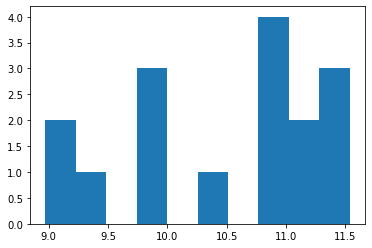

between 8 and 12 hours 16
100.0 %
no. of studies with no W 0
no. of studies with no N1 0
no. of studies with no N2 0
no. of studies with no N3 0
no. of studies with no R 0
no. of studies with no ? 0
(16, 6)
[[209.  80. 466. 136. 118.  54.]
 [207.  43. 362. 144. 137.  76.]
 [ 81.  81. 417. 183. 143.  67.]
 [ 70.  24. 564. 122. 262.  68.]
 [221.  32. 409.  93. 150.  88.]
 [ 43.  58. 285. 281. 183.  97.]
 [ 60.  12. 555. 195. 258.  45.]
 [161.  80. 350. 222.  42.  58.]
 [177.  37. 402. 224. 116. 125.]
 [ 51.  11. 500. 106. 132.  58.]
 [144.  25. 519. 158. 241. 130.]
 [138.  36. 387. 226. 233. 103.]
 [ 95.  11. 504. 251. 187.  50.]
 [285.  23. 326. 251. 104.  92.]
 [156.  20. 529. 255.  79.  81.]
 [116.  32. 386. 280.  72.  93.]]
[8.40833333 7.44166667 7.54166667 8.68333333 7.54166667 7.08333333
 9.         7.125      7.96666667 6.66666667 9.05833333 8.5
 8.73333333 8.24166667 8.65833333 7.38333333]
min 6.666666666666667
max 9.058333333333334
mean 8.002083333333333
median 8.104166666666668

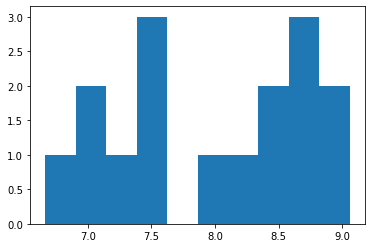

In [19]:
PWS_stages, PWS_sleep_hrs, _, _, _ = getPSGAnnotationStats(PWS_OSA["file_name"])

2401_469 N1
2401_469 N2
2401_469 N3
4060_24697 R
4609_21409 N1
4672_8371 N1
4672_8371 N2
4672_8371 N3
4714_11116 N1
4714_11116 N2
4714_11116 N3
4807_14059 R
8665_5530 N3
8665_5530 R
8782_12283 N1
8782_12283 N2
8782_12283 N3
9820_4195 R
9886_3007 N3
9886_3007 R
11122_7639 R
12664_15928 ?
13636_7507 R
16261_17596 R
18469_4597 R
20713_19624 N3
256.0 Hz 295 79.73 %
400.0 Hz 67 18.11 %
512.0 Hz 8 2.16 %
25.0 85 22.97 %
26.0 213 57.57 %
28.0 11 2.97 %
29.0 60 16.22 %
40.0 1 0.27 %
min (hour) 2.408888888888889
max (hour) 14.223333333333333
mean (hour) 10.32884084084084
median (hour) 10.403333333333332


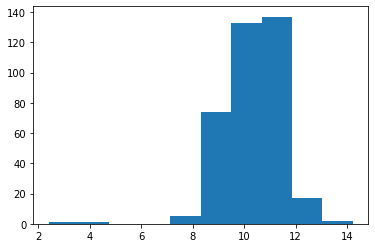

between 8 and 12 hours 353
95.41 %
no. of studies with no W 0
no. of studies with no N1 5
no. of studies with no N2 4
no. of studies with no N3 7
no. of studies with no R 9
no. of studies with no ? 1
(370, 6)
[[119.  22. 439. 196. 157.  68.]
 [301.  28. 342. 201. 191.  52.]
 [ 92.  16. 404. 170. 166.  30.]
 ...
 [401.  93. 329.   0. 102.  26.]
 [120.  42. 425. 163. 116.  78.]
 [185.  20. 372. 186. 178. 135.]]
[ 7.775       8.85833333  7.06666667  6.95833333  9.575       8.975
  9.06666667  7.74166667  7.2         7.35833333  7.54166667  8.01666667
  7.66666667  7.74166667  7.88333333  7.76666667  7.125       7.7
  8.18333333  8.275       7.525       8.15833333  7.06666667  7.36666667
  6.93333333  7.16666667  7.15        7.70833333  8.2         7.625
  7.50833333  7.20833333  7.48333333  8.2         7.34166667  7.15833333
  8.05833333  7.275       7.25833333  7.15        7.45        7.43333333
  8.8         7.7         7.075       7.19166667  2.7         7.50833333
  9.13333333  7.9083

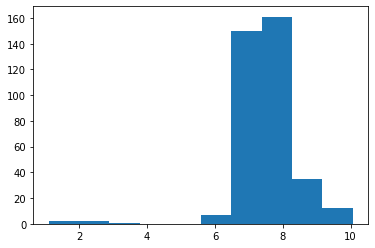

In [20]:
CTRL_stages, CTRL_sleep_hrs, _, _, _ = getPSGAnnotationStats(CTRL_OSA["file_name"])

In [21]:
print('sleep hours')
print(np.mean(PWS_sleep_hrs), np.std(PWS_sleep_hrs))
print(np.mean(CTRL_sleep_hrs), np.std(CTRL_sleep_hrs))

print(scipy.stats.ks_2samp(PWS_sleep_hrs, CTRL_sleep_hrs))
print(scipy.stats.ttest_ind(PWS_sleep_hrs, CTRL_sleep_hrs, equal_var=False))
#print(scipy.stats.ttest_ind(PWS_sleep_hrs, CTRL_sleep_hrs, equal_var=True))
print(scipy.stats.mannwhitneyu(PWS_sleep_hrs, CTRL_sleep_hrs, alternative='two-sided'))
print()

PWS_stages_n = PWS_stages/np.sum(PWS_stages[:,:-1],1)[:, None]
CTRL_stages_n = CTRL_stages/np.sum(CTRL_stages[:,:-1],1)[:, None]

stages = ['W', 'N1', 'N2', 'N3', 'R', 'nREM', 'N1+N2']
    
for i, cols in enumerate([0,1,2,3,4,[1,2,3],[1,2]]):
    if type(cols) == int:
        m1 = 100*PWS_stages_n[:,cols]
        m2 = 100*CTRL_stages_n[:,cols]
    else:
        m1 = 100*np.sum(PWS_stages_n[:,cols], 1)
        m2 = 100*np.sum(CTRL_stages_n[:,cols], 1)
        
    print(stages[i])
    print(np.mean(m1), np.std(m1))
    print(np.mean(m2), np.std(m2))
    print(scipy.stats.ks_2samp(m1, m2))
    print(scipy.stats.ttest_ind(m1, m2, equal_var=False))
#    print(scipy.stats.ttest_ind(m1, m2, equal_var=True))
    print(scipy.stats.mannwhitneyu(m1, m2, alternative='two-sided'))
    print()

sleep hours
8.002083333333333 0.73016300976791
7.523626126126127 0.9143306581376994
KstestResult(statistic=0.35945945945945945, pvalue=0.027872067051430194)
Ttest_indResult(statistic=2.460654087844962, pvalue=0.024888648807670964)
MannwhitneyuResult(statistic=3924.5, pvalue=0.02736415783352536)

W
14.442628734144666 7.128140485554433
20.528845623400898 16.12019058948773
KstestResult(statistic=0.26722972972972975, pvalue=0.1855645790587923)
Ttest_indResult(statistic=-3.008856420717433, pvalue=0.006493400049151209)
MannwhitneyuResult(statistic=2471.0, pvalue=0.2635702100508952)

N1
4.050697911818001 2.6769158118396224
3.5231145054941284 3.350410802919025
KstestResult(statistic=0.21114864864864866, pvalue=0.43849996059514296)
Ttest_indResult(statistic=0.7401110538963119, pvalue=0.4693500334922527)
MannwhitneyuResult(statistic=3477.5, pvalue=0.23672200893374695)

N2
45.23411408032469 7.321439131218954
39.91262387078496 11.450174719494186
KstestResult(statistic=0.3233108108108108, pvalue=0.

min 2.410958904109589
max 23.54794520547945
mean 10.470719178082192
std 5.566291180224885
median 9.663013698630136


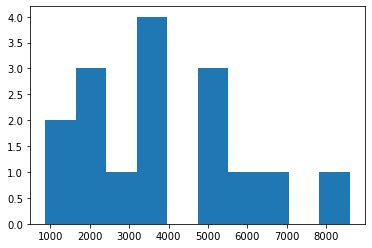

min 1.558904109589041
max 26.353424657534248
mean 13.23407626804887
std 4.720318478968251
median 13.545205479452054


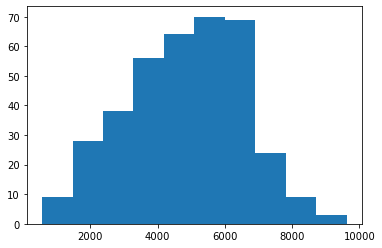

KstestResult(statistic=0.3222972972972973, pvalue=0.06434607878855703)

In [22]:
study_df = ss.info.load_health_info('SLEEP_STUDY.csv')
PWS_ages = study_df.loc[study_df["SLEEP_STUDY_ID"].isin(PWS_OSA["SLEEP_STUDY_ID"]), "AGE_AT_SLEEP_STUDY_DAYS"].values

print('min', np.min(PWS_ages)/365)
print('max', np.max(PWS_ages)/365)
print('mean', np.mean(PWS_ages)/365)
print('std', np.std(PWS_ages/365))
print('median', np.median(PWS_ages)/365)

# print('sleep between 6 and 10 hours')
# print(len(np.where((PWS_ages <10) & (PWS_ages>6))[0]))
# print(np.round(len(np.where((PWS_ages <10) & (sleep_hrs>6))[0])/len(sleep_hrs)*100,2), '%')

plt.hist(PWS_ages)
plt.show()


CTRL_ages = study_df.loc[study_df["SLEEP_STUDY_ID"].isin(CTRL_OSA["SLEEP_STUDY_ID"]), "AGE_AT_SLEEP_STUDY_DAYS"].values
print('min', np.min(CTRL_ages)/365)
print('max', np.max(CTRL_ages)/365)
print('mean', np.mean(CTRL_ages)/365)
print('std', np.std(CTRL_ages/365))
print('median', np.median(CTRL_ages)/365)

# print('sleep between 6 and 10 hours')
# print(len(np.where((PWS_ages <10) & (PWS_ages>6))[0]))
# print(np.round(len(np.where((PWS_ages <10) & (sleep_hrs>6))[0])/len(sleep_hrs)*100,2), '%')

plt.hist(CTRL_ages)
plt.show()

scipy.stats.ks_2samp(PWS_ages, CTRL_ages)

In [23]:
meas_df = ss.info.load_health_info('MEASUREMENT.csv')
PWS_meas = meas_df[(meas_df["STUDY_PAT_ID"].isin(PWS_PTS))& (meas_df["MEAS_TYPE"]=="BMI")]
print(len(PWS_meas))
print(PWS_meas['STUDY_PAT_ID'].nunique())
tmp = PWS_meas[PWS_meas["STUDY_PAT_ID"].isin(PWS_OSA["STUDY_PAT_ID"])]
print(len(tmp))
print(tmp['STUDY_PAT_ID'].nunique())
PWS_meas_psg = PWS_meas[PWS_meas["STUDY_ENC_ID"].isin(PWS_OSA["STUDY_ENC_ID"])]
print(len(PWS_meas_psg))

CTRL_meas = meas_df[(meas_df["STUDY_PAT_ID"].isin(CTRL_PTS))& (meas_df["MEAS_TYPE"]=="BMI")]
print(len(CTRL_meas))
CTRL_meas_psg = CTRL_meas[CTRL_meas["STUDY_ENC_ID"].isin(CTRL_OSA["STUDY_ENC_ID"])]
print(len(CTRL_meas_psg))

1686
34
515
12
14
31633
355


In [24]:
PWS_meas_psg

,STUDY_MEAS_ID,STUDY_PAT_ID,STUDY_ENC_ID,MEAS_RECORDED_DATETIME,MEAS_TYPE,MEAS_VALUE_NUMBER,MEAS_VALUE_TEXT,MEAS_SOURCE,STUDY_PROV_ID
2941,9003291,310,55663096,2019-07-01 20:18:00,BMI,30.23,NaN,BMI,3167125.0
42817,9046295,5659,55777627,2019-07-26 18:51:00,BMI,48.67,NaN,BMI,3177748.0
55747,9060136,7204,56914819,2019-10-28 22:20:00,BMI,43.15,NaN,BMI,3261457.0
103244,9112138,13285,56419228,2019-01-19 22:18:00,BMI,26.64,NaN,BMI,3251506.0
124880,9136472,16321,55836421,2018-09-20 19:58:00,BMI,19.34,NaN,BMI,3277714.0
124885,9136477,16321,56109538,2019-11-19 19:56:00,BMI,18.86,NaN,BMI,3181513.0
155140,9169291,19363,55553044,2018-08-05 18:25:00,BMI,17.11,NaN,BMI,3251506.0
160272,9175074,20104,56289673,2019-03-04 18:57:00,BMI,32.09,NaN,BMI,3177748.0
168829,9184358,310,55708408,2017-10-04 18:15:00,BMI,30.02,NaN,BMI,3265177.0
208827,9227348,5659,56348275,2017-12-19 21:49:00,BMI,42.48,NaN,BMI,3275236.0


In [25]:
print(PWS_meas_psg["STUDY_PAT_ID"].nunique())
PWS_meas_psg


10


,STUDY_MEAS_ID,STUDY_PAT_ID,STUDY_ENC_ID,MEAS_RECORDED_DATETIME,MEAS_TYPE,MEAS_VALUE_NUMBER,MEAS_VALUE_TEXT,MEAS_SOURCE,STUDY_PROV_ID
2941,9003291,310,55663096,2019-07-01 20:18:00,BMI,30.23,NaN,BMI,3167125.0
42817,9046295,5659,55777627,2019-07-26 18:51:00,BMI,48.67,NaN,BMI,3177748.0
55747,9060136,7204,56914819,2019-10-28 22:20:00,BMI,43.15,NaN,BMI,3261457.0
103244,9112138,13285,56419228,2019-01-19 22:18:00,BMI,26.64,NaN,BMI,3251506.0
124880,9136472,16321,55836421,2018-09-20 19:58:00,BMI,19.34,NaN,BMI,3277714.0
124885,9136477,16321,56109538,2019-11-19 19:56:00,BMI,18.86,NaN,BMI,3181513.0
155140,9169291,19363,55553044,2018-08-05 18:25:00,BMI,17.11,NaN,BMI,3251506.0
160272,9175074,20104,56289673,2019-03-04 18:57:00,BMI,32.09,NaN,BMI,3177748.0
168829,9184358,310,55708408,2017-10-04 18:15:00,BMI,30.02,NaN,BMI,3265177.0
208827,9227348,5659,56348275,2017-12-19 21:49:00,BMI,42.48,NaN,BMI,3275236.0
